# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive"

 archive.zip  'Colab Notebooks'   dataset.zip


In [4]:
!cp "/content/drive/My Drive/dataset.zip" "dataset.zip"

In [5]:
! unzip dataset.zip > /dev/null

In [6]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
from sys import stdout
import PIL
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose
device = 'cuda'

# You may add any imports you need

In [7]:
transforms = torchvision.transforms.Compose([
    Resize((224,224)),                                         
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0)), 
])

In [8]:
train_dataset = ImageFolder("./dataset/dataset/train", transform=transforms)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transforms)

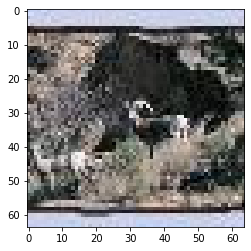

In [9]:
import glob
file = np.random.choice(glob.glob("./dataset/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file))

In [10]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device):
    return_losses=True
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(train_dataloader), file=stdout) as prbar:
        for images, labels in train_dataloader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

def predict(model, val_dataloader, criterion, device):
    model = model.to(device).eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(val_dataloader), file=stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics['loss'], total_predictions, total_labels


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion,
                device=device
            )
        if scheduler is not None:
          scheduler.step()
        epoch_eval_losses.append(validation_metrics[0])
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...

In [13]:
from torchvision.models import resnet18
model_resnet = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [15]:
model_resnet.fc = nn.Linear(512, 200)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), 1e-4)
train_dataloader = train_dataloader
val_dataloader = val_dataloader
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [17]:
all_losses, predicted_labels, true_labels = predict(model_resnet, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.5669 Accuracy: 0.0: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]
tests passed


Запустить обучение можно в ячейке ниже.

In [18]:
train(model_resnet, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 4.0459 Accuracy: 27.5: 100%|██████████| 391/391 [05:16<00:00,  1.23it/s]
Validation Epoch: 0
Loss: 4.1983 Accuracy: 37.5: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Train Epoch: 1
Loss: 3.3306 Accuracy: 45.625: 100%|██████████| 391/391 [05:12<00:00,  1.25it/s]
Validation Epoch: 1
Loss: 3.3035 Accuracy: 37.5: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]
Train Epoch: 2
Loss: 2.9409 Accuracy: 48.75: 100%|██████████| 391/391 [05:13<00:00,  1.25it/s]
Validation Epoch: 2
Loss: 2.518 Accuracy: 56.25: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Train Epoch: 3
Loss: 2.5802 Accuracy: 53.125: 100%|██████████| 391/391 [05:16<00:00,  1.23it/s]
Validation Epoch: 3
Loss: 2.7898 Accuracy: 37.5: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Train Epoch: 4
Loss: 2.3352 Accuracy: 58.75: 100%|██████████| 391/391 [05:12<00:00,  1.25it/s]
Validation Epoch: 4
Loss: 2.3505 Accuracy: 62.5: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Train Epoch: 5
Loss: 2.3158 Accuracy: 5

In [19]:
def evaluate(model, dataloader):
  all_losses, predicted_labels, true_labels = predict(model, dataloader, criterion, device)
  accuracy = accuracy_score(true_labels, predicted_labels)
  return accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [20]:
evaluate(model_resnet, val_dataloader)

Loss: 1.7407 Accuracy: 75.0: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


0.5536

In [21]:
all_losses, predicted_labels, true_labels = predict(model_resnet, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 1.8325 Accuracy: 56.25: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: 
Аугментация уменьшала accuracy, поэтому в этом номере я ее не использовала. Я пробовала еще предобученные vgg19 и vgg16, но выходило очень долго, а accuracy была сопоставима с предобученным resnet

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-_xw7qc23
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_xw7qc23
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=72234 sha256=09f4f5ebf699e625a45fe9bea74ad27979f70c270c3f6812abb61acdc81d2f69
  Stored in directory: /tmp/pip-ephem-wheel-cache-rdclfpxf/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.1
    Uninstalling albumentations-0.5.1:
      Successfully uninstalled albumentations-0.5.1


In [44]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

In [45]:
# we will need this library to process the labeling
! pip install xmltodict

In [46]:
import xmltodict, json

Датасет мы за вас написали.

In [47]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [48]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    ## TODO YOUR CODE
    # dx0, dy0, dx1, dy1 = dt_bbox
    # gx0, gy0, gx1, gy1 = gt_bbox

    # overlap_area = max(max(dx0, gx0) - min(dx1, gx1), 0) * max(max(dy0, gy0) - min(dy1, gy1), 0)
    # union_area = (dx1 - dx0) * (dy1 - dy0) + (gx1 - gx0) * (gy1 - gy0) - overlap_area
    # return overlap_area / union_area

    

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results

def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP'] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]['TP'] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]['TP']) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [49]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {:.4f}".format(a))
        train_one_epoch(model, train_dataloader, optimizer, device=device)


In [50]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
!cp "/content/drive/My Drive/archive.zip" "archive.zip"

In [53]:
! unzip archive.zip > /dev/null

replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
def get_detection_model(num_classes=4):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [56]:
def get_train_transform():
    return A.Compose([
        A.RandomRotate90(p=0.5), 
        A.RGBShift(p=0.2), 
        A.RandomBrightnessContrast(p=0.2), 
        A.HorizontalFlip(p=0.5),
        ToTensor(),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_val_transform():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.2),              
        ToTensor(),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
train_transform = get_train_transform()
val_transform = get_val_transform()

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_detection_model(num_classes)
model.to(device)

# HINT: USE MATERIALS FROM THE SEMINAR
# YOU CAN USE torchvision.models AND torchvision.models.detection
# READ OFFICIAL DOCS FOR MORE INFO
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


indices = torch.randperm(len(train_dataset)).tolist()

train_dataloader = torch.utils.data.DataLoader(train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
    )

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn)

n_epochs = 7

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

AUC ON TEST: 0.0004
Loss value after 10 batches is 0.71
Loss value after 20 batches is 0.62
Loss value after 30 batches is 0.53
Loss value after 40 batches is 0.5
Loss value after 50 batches is 0.47
Loss value after 60 batches is 0.43
Loss value after 70 batches is 0.4
Loss value after 80 batches is 0.38
Loss value after 90 batches is 0.37
Loss value after 100 batches is 0.37
Loss value after 110 batches is 0.36
Loss value after 120 batches is 0.35
AUC ON TEST: 0.8003
Loss value after 10 batches is 0.33
Loss value after 20 batches is 0.27
Loss value after 30 batches is 0.28
Loss value after 40 batches is 0.26
Loss value after 50 batches is 0.26
Loss value after 60 batches is 0.25
Loss value after 70 batches is 0.24
Loss value after 80 batches is 0.24
Loss value after 90 batches is 0.23
Loss value after 100 batches is 0.23
Loss value after 110 batches is 0.23
Loss value after 120 batches is 0.22
AUC ON TEST: 0.8547
Loss value after 10 batches is 0.13
Loss value after 20 batches is 0.17


__Выведите итоговое качество модели__.

In [59]:
auc_ = evaluate(model, val_dataloader, device=device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc_ / 0.91)))

Оценка за это задание составит 4 баллов


In [60]:
auc_

0.9233282568362259

Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [69]:
image1, labels1 = iter(val_dataset[10])
pred = model(image1.unsqueeze(0).to(device))[0]

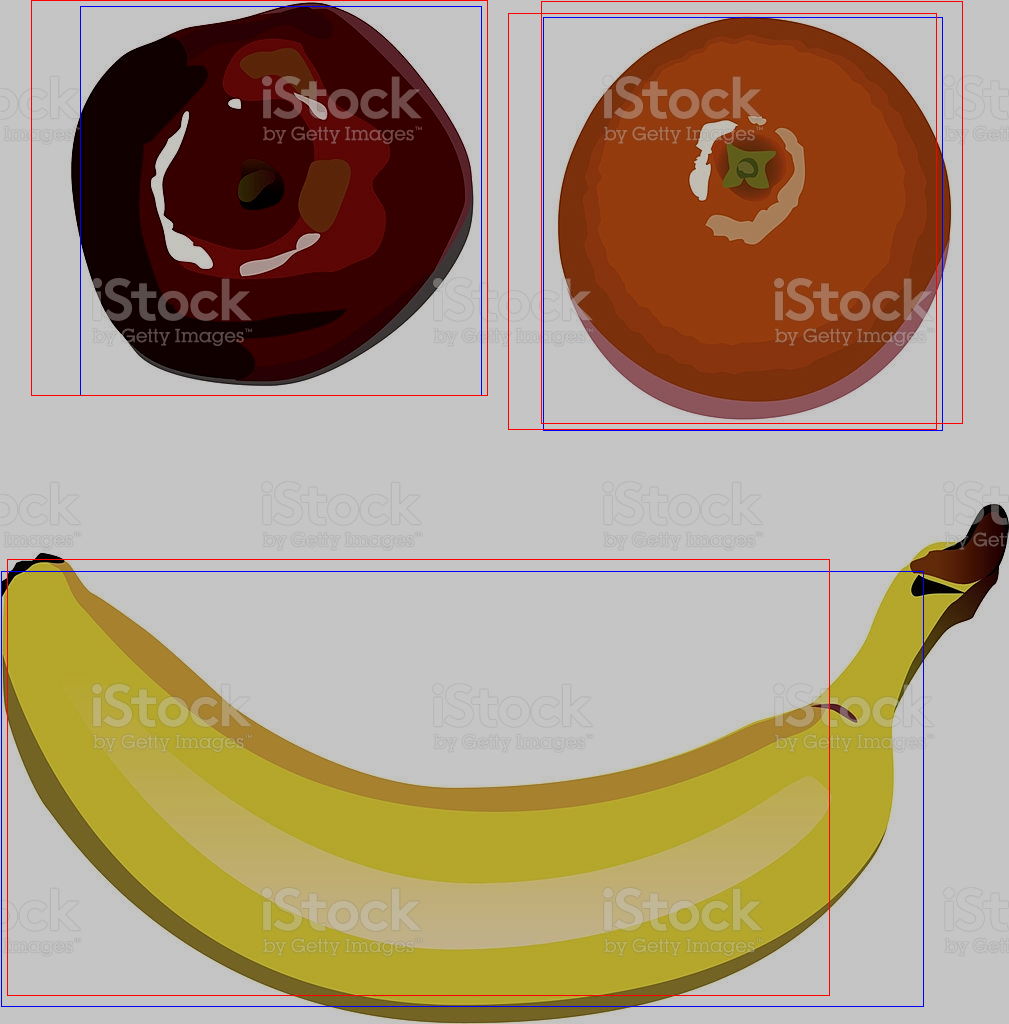

In [70]:
from PIL import ImageDraw

image = T.ToPILImage()(image1)
draw = ImageDraw.Draw(image)
for box in labels1['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

In [65]:
image2, labels2 = iter(val_dataset[18])
pred = model(image2.unsqueeze(0).to(device))[0]

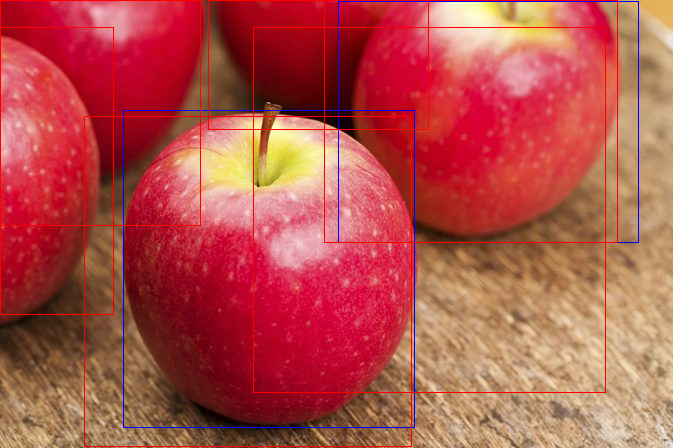

In [66]:
from PIL import ImageDraw

image = T.ToPILImage()(image2)
draw = ImageDraw.Draw(image)
for box in labels2['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.